# Import Dependencies

In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [3]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [4]:
session = Session(engine)

# Check column names and first row

In [5]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24710a6ec48>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [6]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x247121e0f08>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [56]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d').date()
latest_date

datetime.date(2017, 8, 23)

In [57]:
year_ago = latest_date - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [69]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,
       Measurement.prcp]
m_data = session.query(*sel).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

In [70]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_m = pd.DataFrame(m_data, columns=['date', 'prcp'])
#df_m

([], <a list of 0 Text xticklabel objects>)

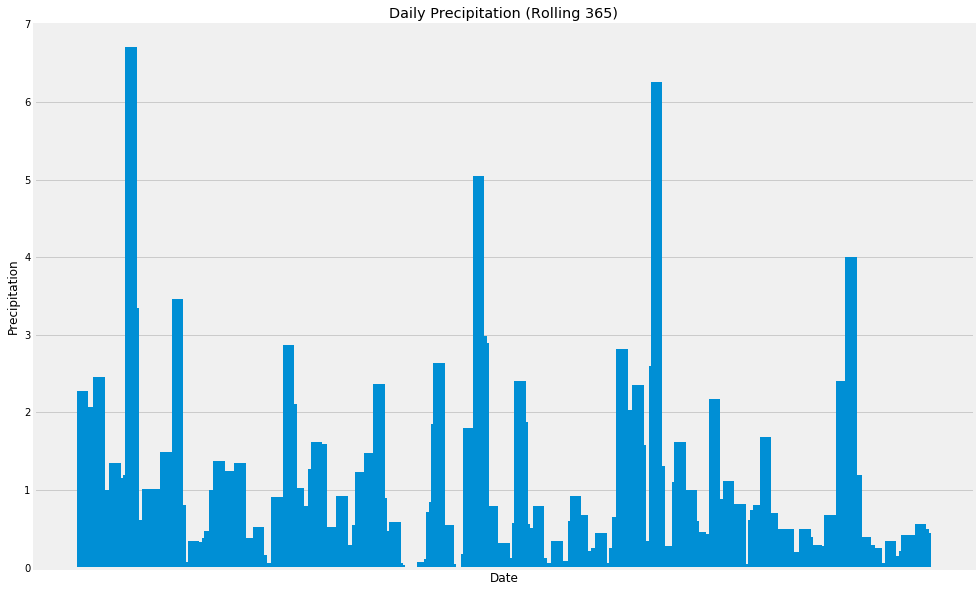

In [72]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.bar(df_m["date"], df_m["prcp"], width=5)
plt.title("Daily Precipitation (Rolling 365)")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.ylim(0, 7)
plt.xticks([])

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_m.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?
station_ct=session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_ct} distinct stations is the Measurement dataset")

There are 9 distinct stations is the Measurement dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_cts=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
df_station_cts = pd.DataFrame(station_cts, columns=['Station', 'Count'])
df_station_cts

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_stats=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
df_station_stats = pd.DataFrame(station_stats, columns=['Min Temp', 'Max Temp', 'Avg Temp'])
df_station_stats

,Min Temp,Max Temp,Avg Temp
0,54.0,85.0,71.663781


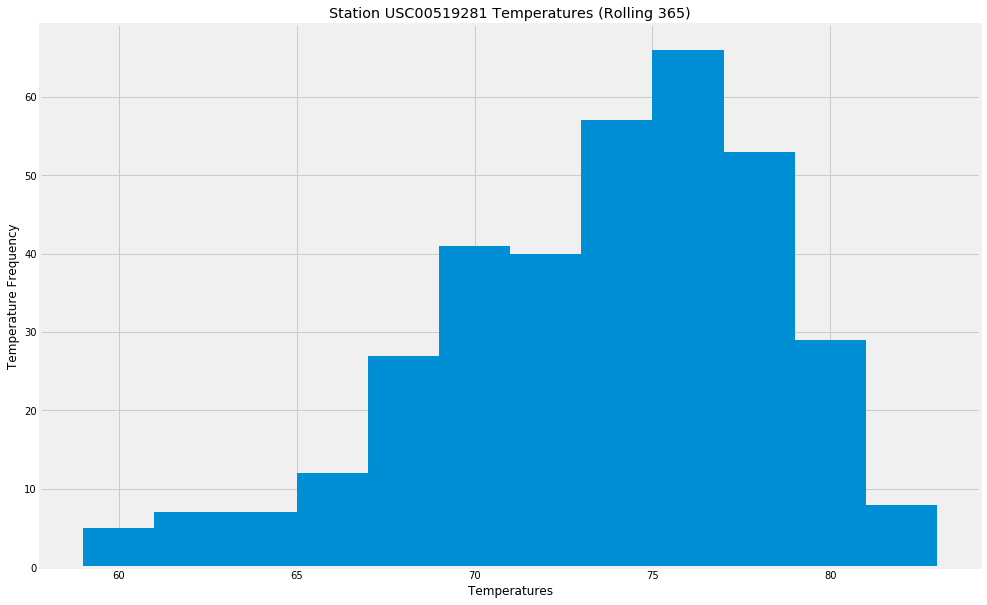

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist_data=session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= dt.date(2017, 8, 23) - dt.timedelta(days=365)).all()

hist_data_df=pd.DataFrame(hist_data)

#plt.hist(hist_data_df["tobs"],bins=12)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.hist(hist_data_df["tobs"],bins=12)
plt.ylabel("Temperature Frequency")
plt.xlabel("Temperatures")
plt.title("Station USC00519281 Temperatures (Rolling 365)")
plt.show()

# Optional Challenge Assignment

### Temperature Analysis I

In [76]:
jun = session.query(Measurement.tobs).filter(func.strftime('%m',Measurement.date)=="06").all()
dec = session.query(Measurement.tobs).filter(func.strftime('%m',Measurement.date)=="12").all()
print('===================================')
print(f'June Avg Temp: {np.ravel(jun).mean()}')
print(f'Dec Avg Temp: {np.ravel(dec).mean()}')
print('===================================')
print(stats.ttest_ind(np.ravel(jun),np.ravel(dec)))
print('===================================')
print(f'The p-value is sufficiently low to reject null hypothesis and surmise significant difference exists between the 2 samples')

June Avg Temp: 74.94411764705882
Dec Avg Temp: 71.04152933421226
Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)
The p-value is sufficiently low to reject null hypothesis and surmise significant difference exists between the 2 samples


### Temperature Analysis II

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [50]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-08-10'
end_date = '2017-08-23'
calc_temps_df = calc_temps(start_date, end_date)
calc_temps_df = pd.DataFrame(calc_temps_df, columns=['Tmin', 'Tavg', 'Tmax'])
calc_temps_df

,Tmin,Tavg,Tmax
0,70.0,78.714286,85.0


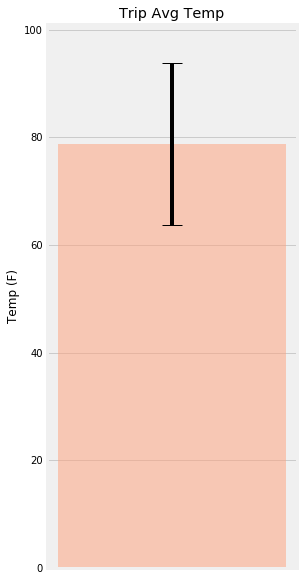

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Tmin = calc_temps_df["Tmin"].iloc[0]
Tavg = calc_temps_df["Tavg"].iloc[0]
Tmax = calc_temps_df["Tmax"].iloc[0]

error = Tmax-Tmin

plt.figure(figsize=(4, 10))
plt.bar(0, Tavg,
        color='lightsalmon',
        width=0.1,
        yerr=error,
        alpha=0.5,
        capsize=10)
plt.ylim(0, 101)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

### Daily Average Rainfall

In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query = "SELECT m.station, s.name, s.latitude, s.longitude, s.elevation, SUM(m.prcp) AS total_prcp FROM measurement AS m "
query = query + "LEFT JOIN station AS s ON s.station = m.station "
query = query + "WHERE m.date BETWEEN '2016-08-10' AND '2016-08-23' "
query = query + "GROUP BY m.station, s.name, s.latitude, s.longitude, s.elevation ORDER BY SUM(m.prcp) DESC;"
df_rain = pd.DataFrame(engine.execute(query).fetchall())
df_rain = df_rain.rename(columns={0:"Station", 1:"Name", 2:"Lat", 3:"Lng", 4:"Elev", 5:"total_prcp"})
df_rain

,Station,Name,Lat,Lng,Elev,total_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,9.42
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.50
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.11
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.84
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.56
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.27
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
trip_dates = []
for i in range(14):
    date = f"09-{10+i}"
    dnorm = daily_normals(date)
    normals.append(dnorm[0])
    trip_dates.append(date)
normals

[(67.0, 76.61224489795919, 85.0),
 (70.0, 76.69565217391305, 83.0),
 (68.0, 75.89795918367346, 85.0),
 (68.0, 75.875, 82.0),
 (69.0, 75.98076923076923, 85.0),
 (67.0, 76.14, 81.0),
 (70.0, 77.40384615384616, 86.0),
 (68.0, 76.57692307692308, 83.0),
 (67.0, 75.85106382978724, 84.0),
 (68.0, 76.34693877551021, 87.0),
 (69.0, 76.14583333333333, 83.0),
 (67.0, 76.44897959183673, 84.0),
 (69.0, 76.37254901960785, 84.0),
 (67.0, 75.82692307692308, 83.0)]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip = pd.DataFrame(normals, columns=["Temp (Lo)", "Temp (Avg)", "Temp (Hi)"])
df_trip["Date"] = trip_dates
df_trip = df_trip.set_index("Date")
df_trip

,Temp (Lo),Temp (Avg),Temp (Hi)
Date,,,
09-10,67.0,76.612245,85.0
09-11,70.0,76.695652,83.0
09-12,68.0,75.897959,85.0
09-13,68.0,75.875000,82.0
09-14,69.0,75.980769,85.0
09-15,67.0,76.140000,81.0
09-16,70.0,77.403846,86.0
09-17,68.0,76.576923,83.0
09-18,67.0,75.851064,84.0


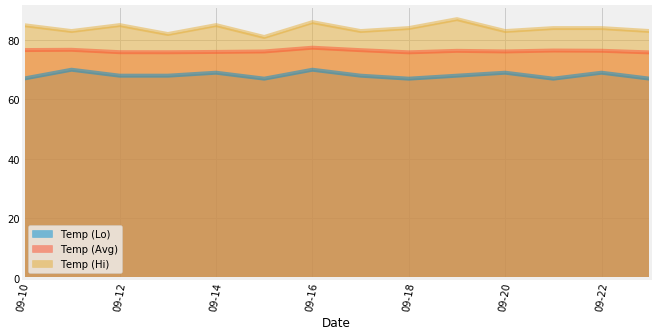

In [45]:
# Plot the daily normals as an area plot with `stacked=False`
df_trip.plot.area(stacked=False, figsize=(10,5), rot=80)